# IMPORT

In [39]:
from collections import namedtuple

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

import numpy as np
import pandas as pd
from timeit import default_timer as timer


from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee

from sklearn.decomposition import PCA
from tqdm.notebook import tqdm, trange
#the line above may fail on google colab so you can use the line below in that case but progress bars will looks less nice
#from tqdm import tqdm, trange
import matplotlib as mpl
import matplotlib.pyplot as plt

ModelClass=GaussianNB


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

# SETUP

In [41]:
SEED = 1 # Set our RNG seed for reproducibility.

n_queries = 75 # You can lower this to decrease run time

# You can increase this to get error bars on your evaluation.
# You probably need to use the parallel code to make this reasonable to compute
n_repeats = 3

# DATA

In [42]:
# define number of classes
begining_index = 4
n_classes = 2
train_class_sizes = [0,0,0,0,300,50,0,0,0,0]
test_class_sizes =  [0,0,0,0,1000,1000,0,0,0,0]

# load train and test sets
train = pd.read_csv('Data/fashion-mnist_train.csv').to_numpy()
test = pd.read_csv('Data/fashion-mnist_test.csv').to_numpy()

X_train = train[:,1:]
y_train = train[:,0]
X_test = test[:,1:]
y_test = test[:,0]

where_train = []
where_test = []
where_pool = []

for label in range(begining_index,begining_index+n_classes):
    where_train.append(np.where(y_train == label)[0][:train_class_sizes[label]])
    where_test.append(np.where(y_test == label)[0][:test_class_sizes[label]])
    where_pool.append(np.where(y_train == label)[0][train_class_sizes[label]:])

def flatten(array):
    new_array = []
    for sublist in array:
        for item in sublist:
            new_array.append(item)
    return new_array
    
where_train = flatten(where_train)
where_test = flatten(where_test)
where_pool = flatten(where_pool)

X_pool = X_train[where_pool]
y_pool = y_train[where_pool]

X_train = X_train[where_train]
y_train = y_train[where_train]

X_test = X_test[where_test]
y_test = y_test[where_test]
    
print("Train data shape:", X_train.shape, "Test data shape:", X_test.shape)
print("Train labels shape:", y_train.shape,"  Test labels shape:", y_test.shape)
print("Pool data shape:", X_pool.shape,"  Pool labels shape:", y_pool.shape)

Train data shape: (350, 784) Test data shape: (2000, 784)
Train labels shape: (350,)   Test labels shape: (2000,)
Pool data shape: (11650, 784)   Pool labels shape: (11650,)


# NAIVE BAYES MODEL

In [43]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))
print("{0}% mislabeled data.".format(((y_test != y_pred).sum()/X_test.shape[0])*100))

mislabeled = [0,0,0,0,0,0,0,0,0,0]
count = [0,0,0,0,0,0,0,0,0,0]
for i in range(len(y_pred)):
    count[int(y_test[i])] += 1
    if y_pred[i] != y_test[i]:
        mislabeled[int(y_test[i])] += 1

print("Mislabeled of class {0}: {1}".format(begining_index,(mislabeled[begining_index]/count[begining_index])*100))
print("Mislabeled of class {0}: {1}".format(begining_index+1,(mislabeled[begining_index+1]/count[begining_index+1])*100))

Number of mislabeled points out of a total 2000 points : 53
2.65% mislabeled data.
Mislabeled of class 4: 0.0
Mislabeled of class 5: 5.3


# Query by comitte

## Passive learner

In [44]:
permutations=[np.random.permutation(X_train.shape[0]) for _ in range(n_repeats)]

In [45]:
random_results = []

for i_repeat in tqdm(range(n_repeats)):
    learner = ModelClass()
    for i_query in tqdm(range(1,n_queries),leave=False):
        query_indices=permutations[i_repeat][:1+i_query]
        learner=learner.fit(X=X_train[query_indices, :], y=y_train[query_indices])
        score = learner.score(X_test, y_test)
        
        random_results.append(ResultsRecord('random', i_query, score))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

## A comittee

In [46]:
n_members=[2, 4, 8, 12]

In [47]:
# SEQUENTIAL VERSION OF THE NEXT CELL
# SLOWER BUT EASIER TO USE IF YOU ARE UNFAMILIAR WITH PARALLEL PROGRAMMING IN PYTHON

committee_results = []

for i_repeat in tqdm(range(n_repeats)):
    for i_members in tqdm(n_members, desc=f'Round (no. members) {i_repeat}',leave=False):
        X_pool = X_train.copy()
        y_pool = y_train.copy()

        start_indices = permutations[i_repeat][:1]

        committee_members = [ActiveLearner(estimator=ModelClass(),
                                           X_training=X_train[start_indices, :],
                                           y_training=y_train[start_indices],
                                           ) for _ in range(i_members)]

        committee = Committee(learner_list=committee_members,
                              query_strategy=vote_entropy_sampling)

        X_pool = np.delete(X_pool, start_indices, axis=0)
        y_pool = np.delete(y_pool, start_indices)

        for i_query in tqdm(range(1, n_queries),desc=f'Points {i_repeat}',leave=False):
            query_idx, query_instance = committee.query(X_pool)

            committee.teach(
                X=X_pool[query_idx].reshape(1, -1),
                y=y_pool[query_idx].reshape(1, )
            )
            committee._set_classes() #this is needed to update for unknown class labels

            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)

            score = committee.score(X_test, y_test)

            committee_results.append(ResultsRecord(
                f'committe_{i_members}',
                i_query,
                score))


  0%|          | 0/3 [00:00<?, ?it/s]

Round (no. members) 0:   0%|          | 0/4 [00:00<?, ?it/s]

Points 0:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 0:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 0:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 0:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Round (no. members) 1:   0%|          | 0/4 [00:00<?, ?it/s]

Points 1:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 1:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 1:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 1:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Round (no. members) 2:   0%|          | 0/4 [00:00<?, ?it/s]

Points 2:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 2:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 2:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

Points 2:   0%|          | 0/74 [00:00<?, ?it/s]

C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:452: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\andre\anaconda3\envs\signaler-exam\lib\site-packages\sklearn\naive_bayes.py:453: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.the

## Compare results

In [48]:
df_results = pd.concat([pd.DataFrame(results)
                        for results in
                        [random_results, committee_results]])

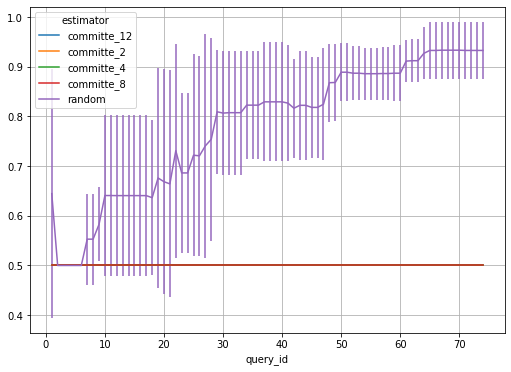

In [49]:

df_results_mean=df_results.groupby(['estimator','query_id']).mean()
df_results_std=df_results.groupby(['estimator','query_id']).std()

df_mean=df_results_mean.reset_index().pivot(index='query_id', columns='estimator', values='score')
df_std=df_results_std.reset_index().pivot(index='query_id', columns='estimator', values='score')

df_mean.plot(figsize=(8.5,6), yerr=df_std)
plt.grid('on')